TrainTonnage Anomaly detection notebook

https://github.com/tosin2013/opcua-asyncio-build-pipelines/blob/main/docs/railroad-mocker.md

https://github.com/tosin2013/edge-anomaly-detection

# Step 1: Install necessary libraries

In [ ]:
!pip install pandas scikit-learn matplotlib onnx skl2onnx statsmodels seaborn joblib onnxruntime

# Step 2: Import libraries

In [316]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import onnx
import onnxruntime as ort
import numpy as np
import skl2onnx
from skl2onnx.common.data_types import FloatTensorType  # Import FloatTensorType
from joblib import dump, load
from sklearn.preprocessing import StandardScaler

# Step 3: Load the data

In [317]:
local_dest_dir = os.path.join(os.getcwd(), 'clean_datasets/')
output_file_path = local_dest_dir + 'edge-datalake-bullet-clean.json'
df = pd.read_json(output_file_path)

# Step 4: Data Exploration

In [318]:

df

,ElapsedTime,TrainSpeed,TrainAcceleration,TrainBraking,OutsideTemperature,Humidity,WindSpeed,PrimarySuspensionStiffness,SecondarySuspensionStiffness,DampingRate,TrainTonnage
0,2023-10-09T20:48:48.112877Z,80,1.000000,0,25,70,15,20000,10000,1000,874.269519
1,2023-10-09T20:48:49.155805Z,80,1.000000,0,25,70,15,20000,10000,1000,874.269519
2,2023-10-09T20:48:50.198377Z,80,1.000000,0,25,70,15,20000,10000,1000,874.269519
3,2023-10-09T20:48:51.241826Z,80,1.000000,0,25,70,15,20000,10000,1000,874.269519
4,2023-10-09T20:48:52.286005Z,80,1.000000,0,25,70,15,20000,10000,1000,874.269519
...,...,...,...,...,...,...,...,...,...,...,...
495,2023-10-09T20:51:19.716357Z,80,1.000000,0,25,70,15,20000,10000,1000,934.381895
496,2023-10-09T20:51:20.762707Z,80,1.000000,0,25,70,15,20000,10000,1000,934.381895
497,2023-10-09T20:51:21.803770Z,80,0.939668,0,25,70,15,20000,10000,1000,934.381895
498,2023-10-09T20:51:22.850378Z,80,1.000000,0,25,70,15,20000,10000,1000,934.381895


# Step 5: Preprocess the data (remove rows with missing values)

In [319]:
df.TrainTonnage

0      874.269519
1      874.269519
2      874.269519
3      874.269519
4      874.269519
          ...    
495    934.381895
496    934.381895
497    934.381895
498    934.381895
499    934.381895
Name: TrainTonnage, Length: 500, dtype: float64

# Step 6: Make an Isolation Forest Model

In [320]:
from sklearn.ensemble import IsolationForest

# Anomaly detection using Isolation Forest
clf = IsolationForest(contamination=0.1)  # contamination is the proportion of outliers in the data
df['anomaly'] = clf.fit_predict(df.iloc[:, 1:])

# Create an Isolation Forest model
clf = IsolationForest(contamination=0.1)

# Fit the model to the data
clf.fit(df.iloc[:, 1:])

# Convert the `ElapsedTime` column to datetime format
df['ElapsedTime'] = pd.to_datetime(df['ElapsedTime'])

# Predict whether each data point is an outlier
df['anomaly'] = clf.predict(df.iloc[:, 1:])

# Calculate the score for each data point
scores = clf.decision_function(df.iloc[:, 1:])

# Add the scores to the DataFrame
df['scores'] = scores

# Print the DataFrame
print(df)


/opt/app-root/lib64/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


                         ElapsedTime  TrainSpeed  TrainAcceleration  \
0   2023-10-09 20:48:48.112877+00:00          80           1.000000   
1   2023-10-09 20:48:49.155805+00:00          80           1.000000   
2   2023-10-09 20:48:50.198377+00:00          80           1.000000   
3   2023-10-09 20:48:51.241826+00:00          80           1.000000   
4   2023-10-09 20:48:52.286005+00:00          80           1.000000   
..                               ...         ...                ...   
495 2023-10-09 20:51:19.716357+00:00          80           1.000000   
496 2023-10-09 20:51:20.762707+00:00          80           1.000000   
497 2023-10-09 20:51:21.803770+00:00          80           0.939668   
498 2023-10-09 20:51:22.850378+00:00          80           1.000000   
499 2023-10-09 20:51:23.891622+00:00          80           1.000000   

     TrainBraking  OutsideTemperature  Humidity  WindSpeed  \
0               0                  25        70         15   
1               0      

# Step 7: Show Anomalies

In [321]:

# Print rows which are anomalies
anomalies = df[df['anomaly'] == -1]

anomalies


,ElapsedTime,TrainSpeed,TrainAcceleration,TrainBraking,OutsideTemperature,Humidity,WindSpeed,PrimarySuspensionStiffness,SecondarySuspensionStiffness,DampingRate,TrainTonnage,anomaly,scores
109,2023-10-09 20:51:34.334278+00:00,80,0.767870,0,25,70,15,20000,10000,1000,934.381895,-1,-0.142045
122,2023-10-09 20:51:47.903029+00:00,80,0.815059,0,25,70,15,20000,10000,1000,934.381895,-1,-0.142045
139,2023-10-09 20:52:05.693831+00:00,80,0.974222,0,25,70,15,20000,10000,1000,934.381895,-1,-0.157262
140,2023-10-09 20:52:06.736372+00:00,80,0.818935,0,25,70,15,20000,10000,1000,934.381895,-1,-0.145794
145,2023-10-09 20:52:11.960974+00:00,80,0.741093,0,25,70,15,20000,10000,1000,934.381895,-1,-0.141871
203,2023-10-09 20:52:20.368998+00:00,80,0.685825,0,25,70,15,20000,10000,1000,934.381895,-1,-0.138116
204,2023-10-09 20:52:21.411305+00:00,80,0.648467,0,25,70,15,20000,10000,1000,934.381895,-1,-0.125227
208,2023-10-09 20:52:25.589476+00:00,80,0.542841,0,25,70,15,20000,10000,1000,934.381895,-1,-0.122524
209,2023-10-09 20:52:26.650193+00:00,80,0.631191,0,25,70,15,20000,10000,1000,934.381895,-1,-0.117520
210,2023-10-09 20:52:27.692277+00:00,80,0.993541,0,25,70,15,20000,10000,1000,934.381895,-1,-0.154649


# Step 8: Check the Correlations in the Data
The correlation matrix provides insights into how pairs of variables are related to each other, which can be valuable for understanding the dataset's underlying patterns and making informed decisions in data analysis.

In [322]:
correlation_matrix = df.corr()
print(correlation_matrix)

                              TrainSpeed  TrainAcceleration  TrainBraking  \
TrainSpeed                           NaN                NaN           NaN   
TrainAcceleration                    NaN           1.000000           NaN   
TrainBraking                         NaN                NaN           NaN   
OutsideTemperature                   NaN                NaN           NaN   
Humidity                             NaN                NaN           NaN   
WindSpeed                            NaN                NaN           NaN   
PrimarySuspensionStiffness           NaN                NaN           NaN   
SecondarySuspensionStiffness         NaN                NaN           NaN   
DampingRate                          NaN                NaN           NaN   
TrainTonnage                         NaN           0.115153           NaN   
anomaly                              NaN           0.826682           NaN   
scores                               NaN           0.744007           NaN   

/tmp/ipykernel_3498/2020863294.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


# Step 9: Check fo  Missing Data in the Dataset
Identifying missing data is crucial as it allows us to assess data quality and decide on appropriate strategies for handling missing values during data preprocessing and analysis."

In [323]:
missing_data = df.isnull().sum()
print("Missing values for each column:\n", missing_data)

Missing values for each column:
 ElapsedTime                     0
TrainSpeed                      0
TrainAcceleration               0
TrainBraking                    0
OutsideTemperature              0
Humidity                        0
WindSpeed                       0
PrimarySuspensionStiffness      0
SecondarySuspensionStiffness    0
DampingRate                     0
TrainTonnage                    0
anomaly                         0
scores                          0
dtype: int64


# Step 10: Detect Negative Values in the 'TrainSpeed' Column
The presence of negative values in this column can be problematic, and detecting them is a critical step in data validation and quality assurance. If negative values are found, further investigation and data cleansing may be necessary to ensure the integrity of the dataset.

In [324]:
if (df['TrainSpeed'] < 0).any():
    print("There are negative values in 'TrainSpeed'")


# Step 11: Review the Seasonal Decomposition of 'TrainTonnage' Data
Seasonal decomposition helps in understanding the underlying seasonal and trend components within a time series. In this case, the 'additive' model is used, and the period is set to 1, which should be adjusted according to the data's frequency. The resulting plot shows the original data, trend component, seasonal component, and residuals, providing insights into the data's underlying patterns and variations.

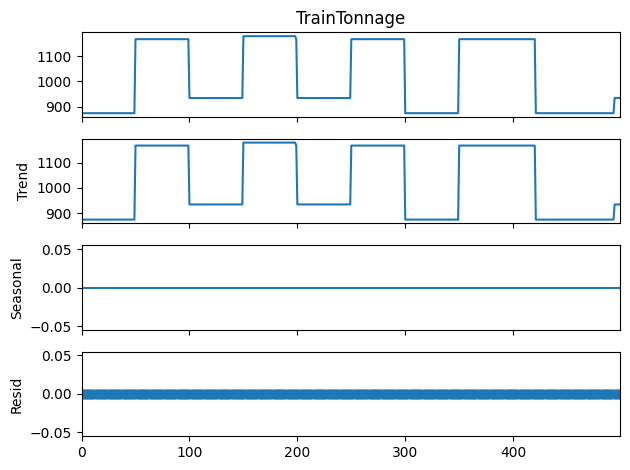

In [325]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['TrainTonnage'], model='additive', period=1)  # Adjust period based on data frequency
result.plot()
plt.show()

# Step 12: Print the Anomaly Scores and Correlation Matrix

In [326]:
# Print the scores
print(df['scores'])

# Print the correlation matrix
print(df.corr())

0      0.076422
1      0.076422
2      0.076422
3      0.076422
4      0.076422
         ...   
495    0.047563
496    0.047563
497   -0.169305
498    0.047563
499    0.047563
Name: scores, Length: 500, dtype: float64
                              TrainSpeed  TrainAcceleration  TrainBraking  \
TrainSpeed                           NaN                NaN           NaN   
TrainAcceleration                    NaN           1.000000           NaN   
TrainBraking                         NaN                NaN           NaN   
OutsideTemperature                   NaN                NaN           NaN   
Humidity                             NaN                NaN           NaN   
WindSpeed                            NaN                NaN           NaN   
PrimarySuspensionStiffness           NaN                NaN           NaN   
SecondarySuspensionStiffness         NaN                NaN           NaN   
DampingRate                          NaN                NaN           NaN   
TrainTonnage

/tmp/ipykernel_3498/2851838352.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr())


# Step 13: Train Tonnage Over Time with Anomalies Highlighted
This visualization illustrates the variation in train tonnage over time, with anomalies highlighted in red. 

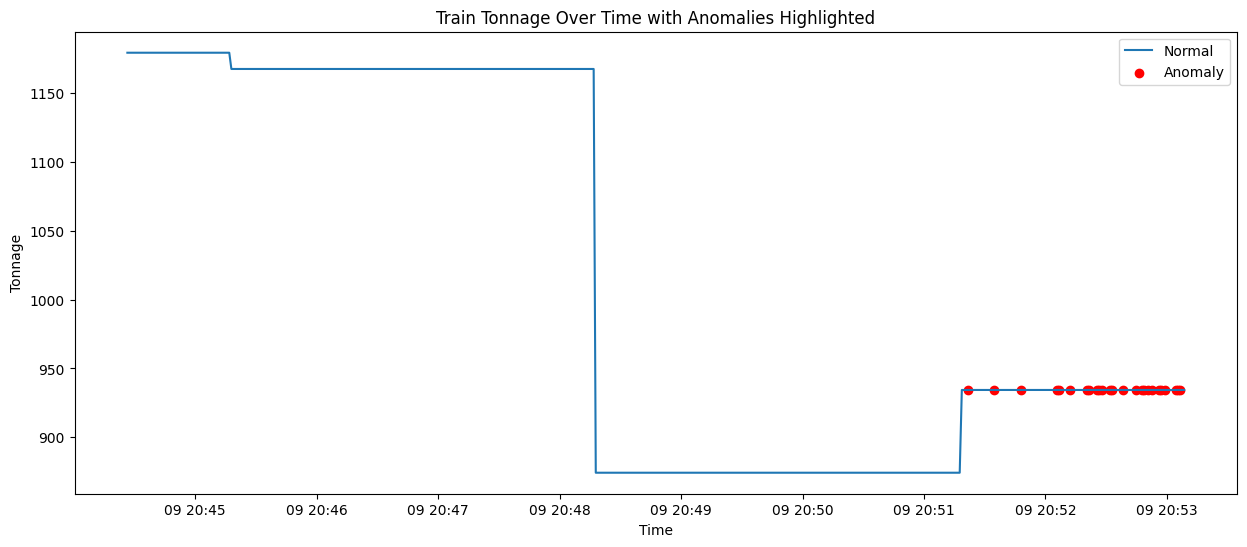

In [328]:
plt.figure(figsize=(15, 6))
df = df.sort_values(by='ElapsedTime')
plt.plot(df['ElapsedTime'], df['TrainTonnage'], label='Normal')
plt.scatter(df[df['anomaly']==-1]['ElapsedTime'], df[df['anomaly']==-1]['TrainTonnage'], color='red', label='Anomaly')
plt.title('Train Tonnage Over Time with Anomalies Highlighted')
plt.xlabel('Time')
plt.ylabel('Tonnage')
plt.legend()
plt.show()

# Step 14: List Detected Anomalies in Train Tonnage Data
This list displays the timestamps of detected anomalies in the train tonnage data

In [329]:
anomaly_times = df[df['anomaly']==-1]['ElapsedTime']
print("Timestamps of detected anomalies:\n", anomaly_times)

Timestamps of detected anomalies:
 497   2023-10-09 20:51:21.803770+00:00
109   2023-10-09 20:51:34.334278+00:00
122   2023-10-09 20:51:47.903029+00:00
139   2023-10-09 20:52:05.693831+00:00
140   2023-10-09 20:52:06.736372+00:00
145   2023-10-09 20:52:11.960974+00:00
203   2023-10-09 20:52:20.368998+00:00
204   2023-10-09 20:52:21.411305+00:00
208   2023-10-09 20:52:25.589476+00:00
209   2023-10-09 20:52:26.650193+00:00
210   2023-10-09 20:52:27.692277+00:00
214   2023-10-09 20:52:31.863618+00:00
215   2023-10-09 20:52:32.907652+00:00
220   2023-10-09 20:52:38.161521+00:00
226   2023-10-09 20:52:44.471221+00:00
229   2023-10-09 20:52:47.606638+00:00
230   2023-10-09 20:52:48.648458+00:00
232   2023-10-09 20:52:50.736769+00:00
234   2023-10-09 20:52:52.822756+00:00
237   2023-10-09 20:52:55.952540+00:00
238   2023-10-09 20:52:56.996500+00:00
240   2023-10-09 20:52:59.116084+00:00
245   2023-10-09 20:53:04.336771+00:00
246   2023-10-09 20:53:05.380533+00:00
247   2023-10-09 20:53:06.426

# Step 15: Visualize of All Dataframe Columns
The plot visualizes all columns in the dataframe over the data index. Each line represents a different column, and it provides a comprehensive view of how each feature changes over time or index values.

ElapsedTime
TrainSpeed
TrainAcceleration
TrainBraking
OutsideTemperature
Humidity
WindSpeed
PrimarySuspensionStiffness
SecondarySuspensionStiffness
DampingRate
TrainTonnage
anomaly
scores


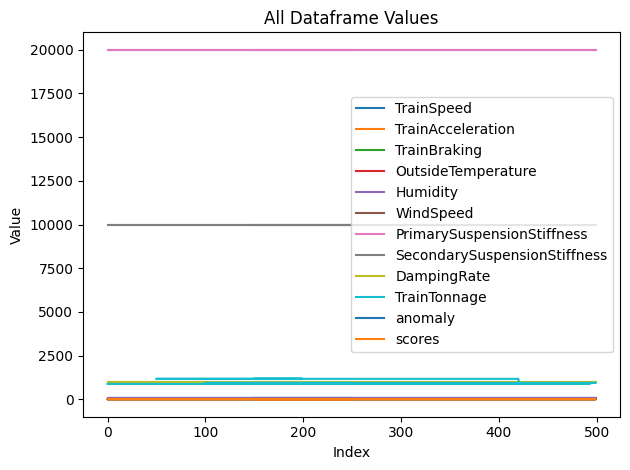

In [330]:
# Plot all columns
for column in df.columns:
    print(column)

    if column != 'ElapsedTime':
        df[column].plot(label=column)

plt.title("All Dataframe Values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# Step 16: Visualize All Anomalies Dataframe Columns
This plot displays all columns in the anomalies dataframe over the data index. 

ElapsedTime
TrainSpeed
TrainAcceleration
TrainBraking
OutsideTemperature
Humidity
WindSpeed
PrimarySuspensionStiffness
SecondarySuspensionStiffness
DampingRate
TrainTonnage
anomaly
scores


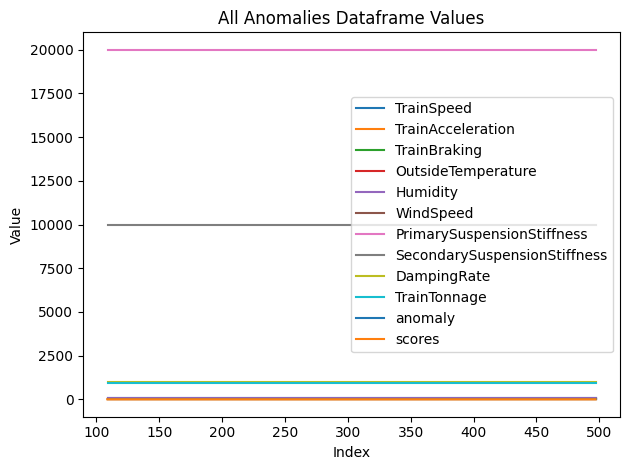

In [332]:
# Plot all columns
for column in anomalies.columns:
    print(column)

    if column != 'ElapsedTime':
        anomalies[column].plot(label=column)

plt.title("All Anomalies Dataframe Values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# Step 17: Correlation Heatmap
This heatmap provides a visual representation of the correlation between different variables in the dataset. Each cell in the heatmap represents the correlation coefficient between two variables, with annotations to indicate the exact correlation values. 

/tmp/ipykernel_3498/4131398106.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm')


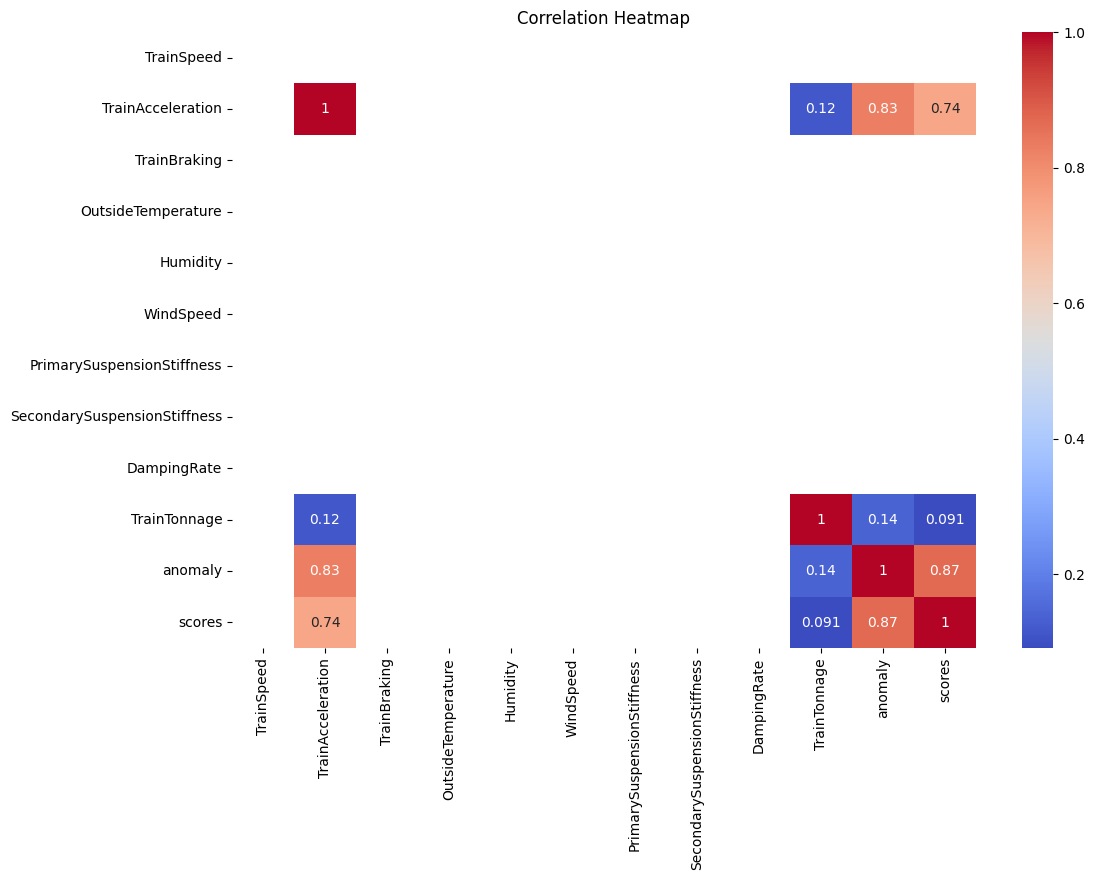

In [333]:
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Step 18: Review Box Plot of Key Features
This box plot visualization provides insights into the distribution of key features in the dataset, including 'TrainSpeed,' 'TrainAcceleration,' and 'TrainTonnage.' Each box represents the interquartile range (IQR) of the respective feature, with the central line indicating the median value. Outliers, if present, are represented as individual points outside the whiskers of the box.

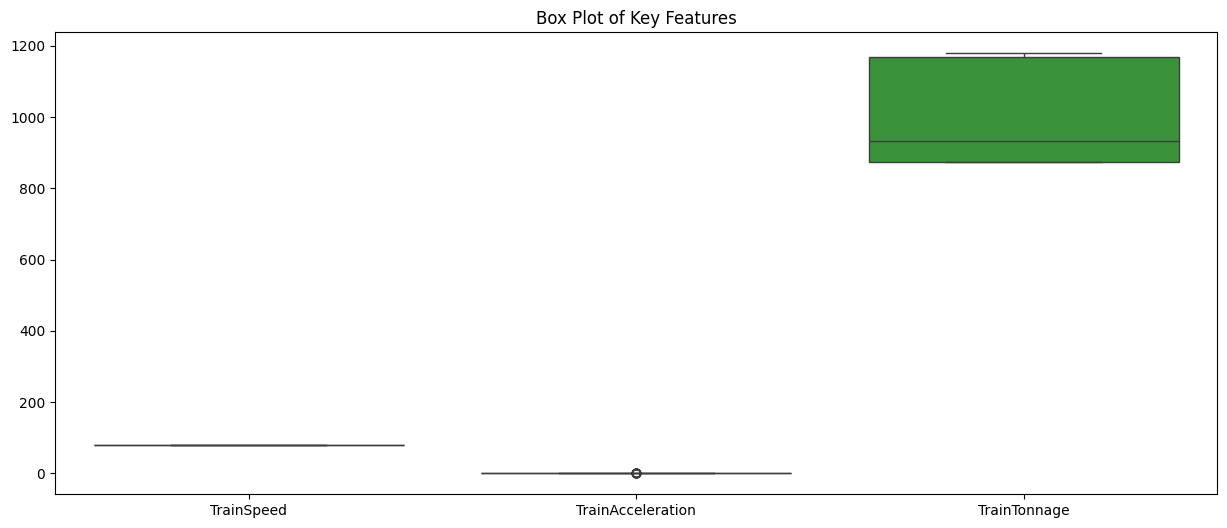

In [ ]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df[['TrainSpeed', 'TrainAcceleration', 'TrainTonnage']])
plt.title('Box Plot of Key Features')
plt.show()


# Step 19: Pairwise Scatter Plot of Key Features
This pair plot visualization illustrates the pairwise relationships between key features in the dataset, including 'TrainSpeed,' 'TrainAcceleration,' and 'TrainTonnage.' Each scatterplot shows the correlation and distribution of two features. The diagonal line displays histograms of individual features.

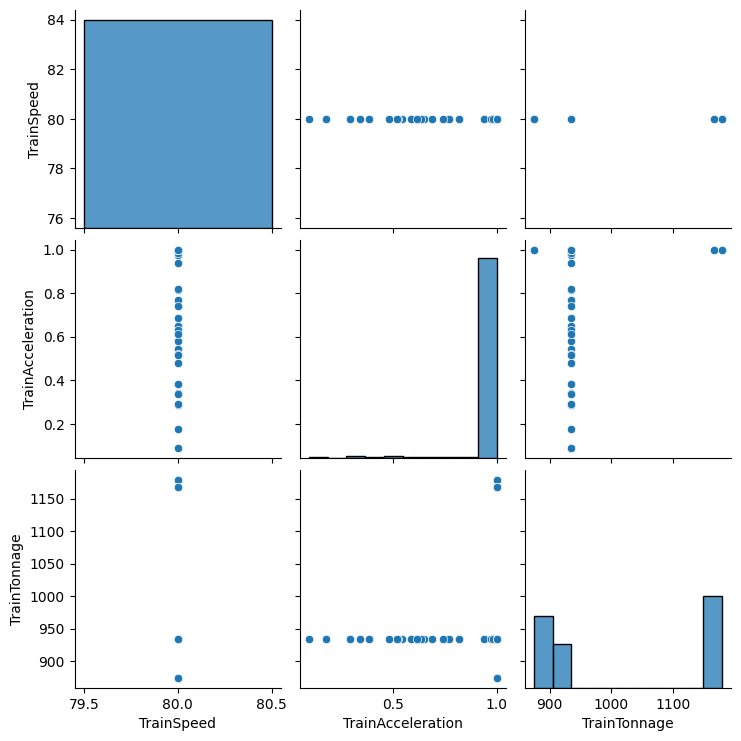

In [335]:
sns.pairplot(df[['TrainSpeed', 'TrainAcceleration', 'TrainTonnage']])
plt.show()

# Step 20: Scatter Plot of Primary Suspension Stiffness vs. Train Acceleration
This scatter plot illustrates the relationship between 'PrimarySuspensionStiffness' and 'TrainAcceleration.' The green dots represent normal data points, while the red dots indicate anomalies. 

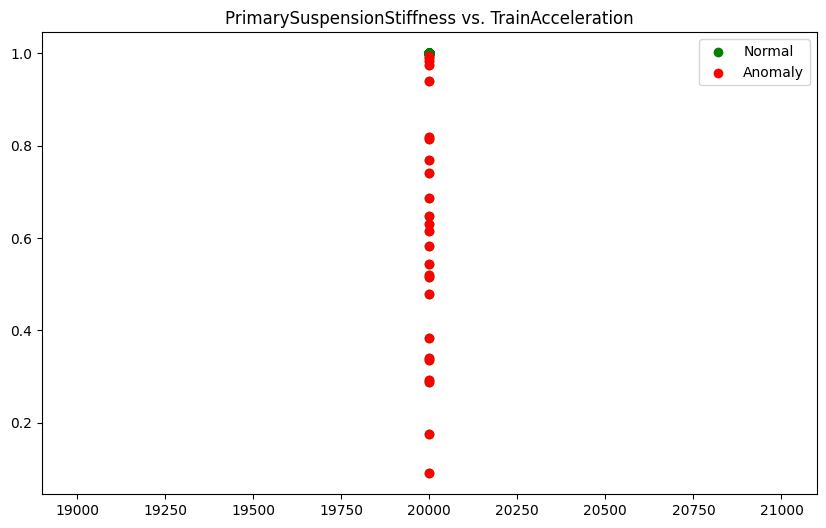

In [336]:
plt.figure(figsize=(10, 6))
plt.scatter(df['PrimarySuspensionStiffness'], df['TrainAcceleration'],  color='green', label='Normal')
plt.scatter(anomalies['PrimarySuspensionStiffness'], anomalies['TrainAcceleration'], color='red', label='Anomaly')
plt.title("PrimarySuspensionStiffness vs. TrainAcceleration")
plt.legend()
plt.show()


# Step 21: Scatter Plot of Train Tonnage vs. Elapsed Time
This scatter plot visualizes the relationship between 'TrainTonnage' and 'ElapsedTime' for a dataset. Each green point represents a normal observation. The x-axis represents 'TrainTonnage,' which measures the weight or load of the train, and the y-axis represents 'ElapsedTime,' which is the time at which each observation was recorded. 

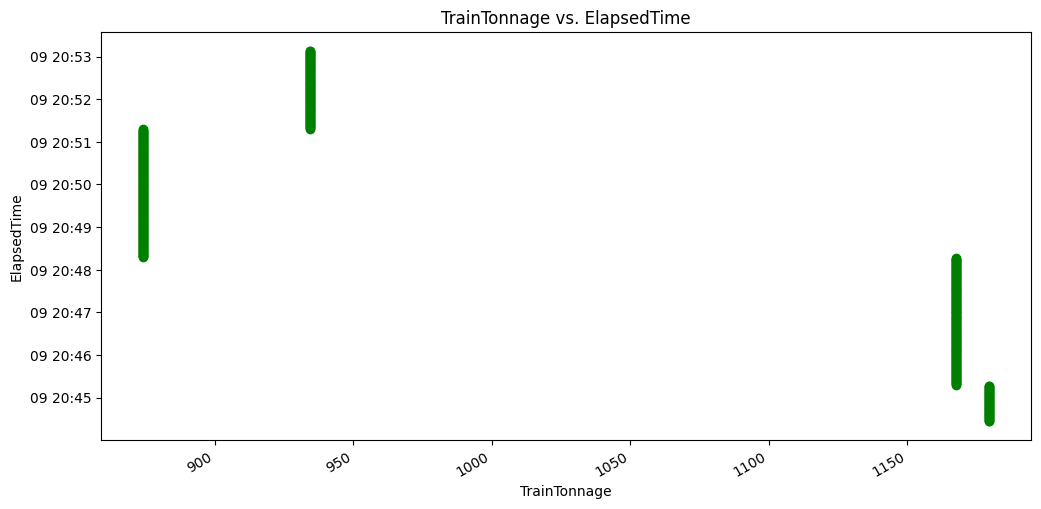

This suggests that there is a negative correlation between these two variables, meaning that as TrainTonnage increases, ElapsedTime tends to decrease.


In [337]:
# Convert the `ElapsedTime` column to datetime format
df['ElapsedTime'] = pd.to_datetime(df['ElapsedTime'])

# Create a scatter plot of TrainTonnage vs. ElapsedTime
plt.figure(figsize=(12, 6))
plt.scatter(df['TrainTonnage'], df['ElapsedTime'], color='green', label='Normal')

# Automatically format the x-axis labels as dates and times
plt.gcf().autofmt_xdate()

# Set plot title, x-axis label, and y-axis label
plt.title("TrainTonnage vs. ElapsedTime")
plt.xlabel("TrainTonnage")
plt.ylabel("ElapsedTime")

# Show the plot
plt.show()
print("This suggests that there is a negative correlation between these two variables, meaning that as TrainTonnage increases, ElapsedTime tends to decrease.")

# Step 22: Scatter Plot of Train Tonnage vs. Anomaly Scores
This scatter plot visualizes the relationship between 'TrainTonnage' and 'Anomaly Scores' for a dataset. Each green point represents a normal observation, while red points represent anomalies. The x-axis represents 'TrainTonnage,' which measures the weight or load of the train, and the y-axis represents 'Anomaly Scores' generated by an anomaly detection model. 

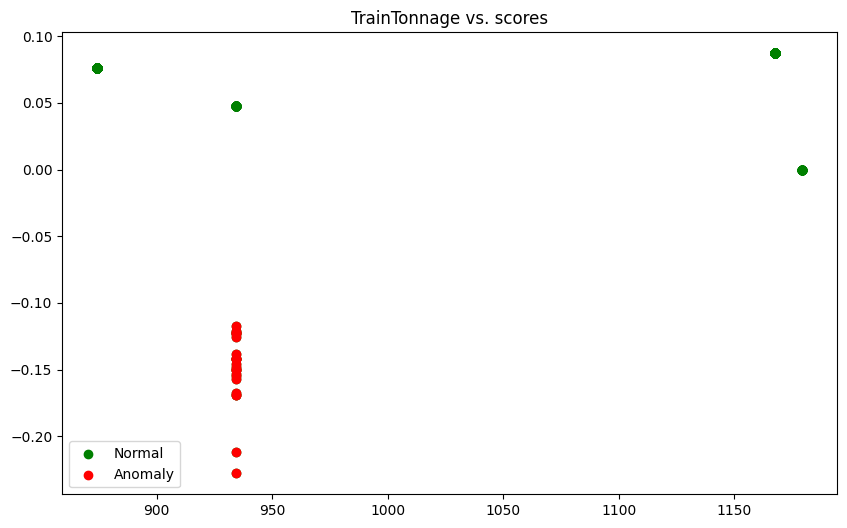

In [338]:
# Create a scatter plot of TrainTonnage vs. scores
plt.figure(figsize=(10, 6))
plt.scatter(df['TrainTonnage'], df['scores'], color='green', label='Normal')
plt.scatter(anomalies['TrainTonnage'], anomalies['scores'], color='red', label='Anomaly')
plt.title("TrainTonnage vs. scores")
plt.legend()
plt.show()

# Step 23: Scatter Plot of Anomaly vs. Anomaly Scores
This scatter plot visualizes the relationship between 'Anomaly' labels and 'Anomaly Scores' for a dataset. Each green point represents a normal observation (anomaly label 0), while red points represent anomalies (anomaly label -1). The x-axis represents 'Anomaly' labels, where 0 indicates a normal data point, and -1 indicates an anomaly detected by an anomaly detection model. The y-axis represents 'Anomaly Scores' generated by the model. 

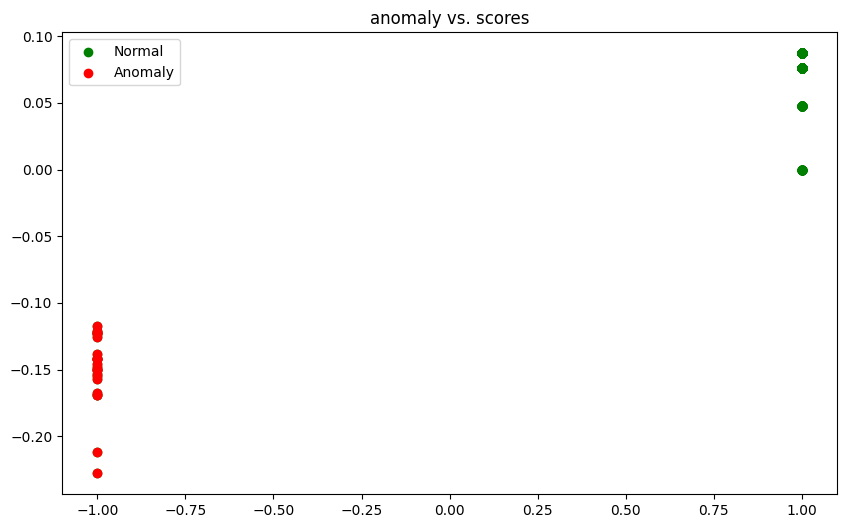

In [339]:
# Create a scatter plot of anomaly vs. scores
plt.figure(figsize=(10, 6))
plt.scatter(df['anomaly'], df['scores'], color='green', label='Normal')
plt.scatter(anomalies['anomaly'], anomalies['scores'], color='red', label='Anomaly')
plt.title("anomaly vs. scores")
plt.legend()
plt.show()

# Step 24: Scatter Plot of TrainSpeed vs. TrainAcceleration with Correlation Line
This scatter plot illustrates the relationship between 'TrainSpeed' and 'TrainAcceleration' features in a dataset. Each green point represents a normal observation, while red points represent anomalies. The x-axis shows 'TrainSpeed,' and the y-axis shows 'TrainAcceleration.' Additionally, a dashed black line is added to the plot to represent the correlation between 'TrainSpeed' and 'TrainAcceleration.' 

/tmp/ipykernel_3498/2298899256.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


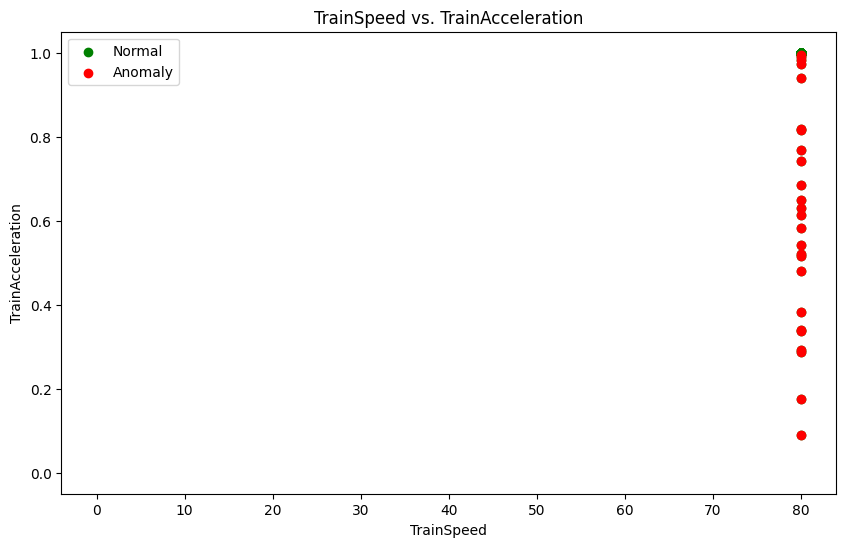

In [340]:
# Calculate the correlation matrix
corr = df.corr()

# Extract the correlation between TrainSpeed and TrainAcceleration
train_speed_train_acceleration_corr = corr.loc['TrainSpeed', 'TrainAcceleration']

# Create a scatter plot of TrainSpeed vs. TrainAcceleration
plt.figure(figsize=(10, 6))
plt.scatter(df['TrainSpeed'], df['TrainAcceleration'], color='green', label='Normal')
plt.scatter(df[df['anomaly'] == -1]['TrainSpeed'], df[df['anomaly'] == -1]['TrainAcceleration'], color='red', label='Anomaly')
plt.title("TrainSpeed vs. TrainAcceleration")
plt.xlabel("TrainSpeed")
plt.ylabel("TrainAcceleration")
plt.legend()

# Add a line to the plot that shows the correlation between TrainSpeed and TrainAcceleration
plt.plot([0, 100], [0, train_speed_train_acceleration_corr * 100], color='black', linestyle='dashed')
plt.annotate('Correlation: {}'.format(train_speed_train_acceleration_corr), (50, 50), fontsize=12)

# Show the plot
plt.show()

# Step 25: Model Conversion to ONNX Format
This code snippet demonstrates the conversion of a scikit-learn model ('clf') into the ONNX format for compatibility with various machine learning frameworks and deployment platforms. 

In [342]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# Define the model's input type
initial_type = [('float_input', FloatTensorType([None, 11]))]  # Assuming input has 11 features

try:
    # Try to convert the model to ONNX format
    onnx_model = convert_sklearn(clf, initial_types=initial_type)
    # Save the model in ONNX format
    with open("model.onnx", "wb") as f:
        f.write(onnx_model.SerializeToString())
    print("Model converted to ONNX format and saved successfully!")
except Exception as e:
    print(f"Error: {str(e)}")



Model converted to ONNX format and saved successfully!


# Step 26: Load an ONNX Model for Inference

In [343]:
# Load the ONNX model
onnx_model_path = "model.onnx"
session = ort.InferenceSession(onnx_model_path)

# Step 27: List Features in a Sample DataFrame
This code snippet prints the list of features (column names) contained in the DataFrame df_sample. 

In [344]:
# Print the list of features (column names) in df_sample
print("Features in df_sample:")
print(df_sample.columns)

Features in df_sample:
Index(['TrainSpeed', 'TrainAcceleration', 'TrainBraking', 'OutsideTemperature',
       'Humidity', 'WindSpeed', 'PrimarySuspensionStiffness',
       'SecondarySuspensionStiffness', 'DampingRate', 'TrainTonnage',
       'anomaly', 'scores'],
      dtype='object')


# Step 28: Feature Extraction and Inference
In this code snippet, relevant features are extracted from the DataFrame df_sample. These features, namely 'TrainSpeed', 'TrainAcceleration', 'TrainBraking', 'OutsideTemperature', 'Humidity', 'WindSpeed', 'PrimarySuspensionStiffness', 'SecondarySuspensionStiffness', 'DampingRate', 'TrainTonnage', and 'anomaly', are selected for further processing or inference.

In [345]:

# Extract the relevant features from df_sample (adjust as needed)
input_data = df_sample[['TrainSpeed', 'TrainAcceleration', 'TrainBraking', 'OutsideTemperature',
       'Humidity', 'WindSpeed', 'PrimarySuspensionStiffness',
       'SecondarySuspensionStiffness', 'DampingRate', 'TrainTonnage',
       'anomaly']].values  # Replace with actual feature names


# Step 29: Inference using ONNX Model
This code snippet demonstrates how to perform inference using an ONNX model. It takes input data, converts it to the required data type, and feeds it into the model to obtain predictions or results. 

In [346]:
# Perform inference
output = session.run(None, {"float_input": input_data.astype(np.float32)})

# Step 30: Visualizing Model Output with a Bar Chart

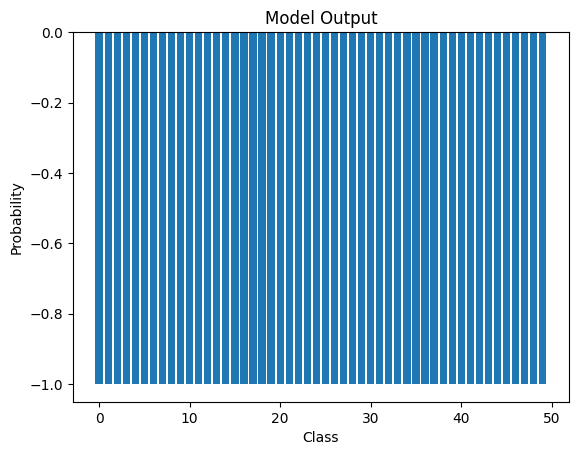

In [347]:
# Assuming 'output' is a numpy array with the results
# You can create a bar chart to visualize the output values
plt.bar(range(len(output[0])), output[0].flatten())  # Use flatten() to convert to 1D array
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Model Output')
plt.show()

# Step 31: Visualizing Anomaly Scores with a Bar Chart
This code snippet demonstrates how to visualize anomaly scores for a set of data points using a bar chart.

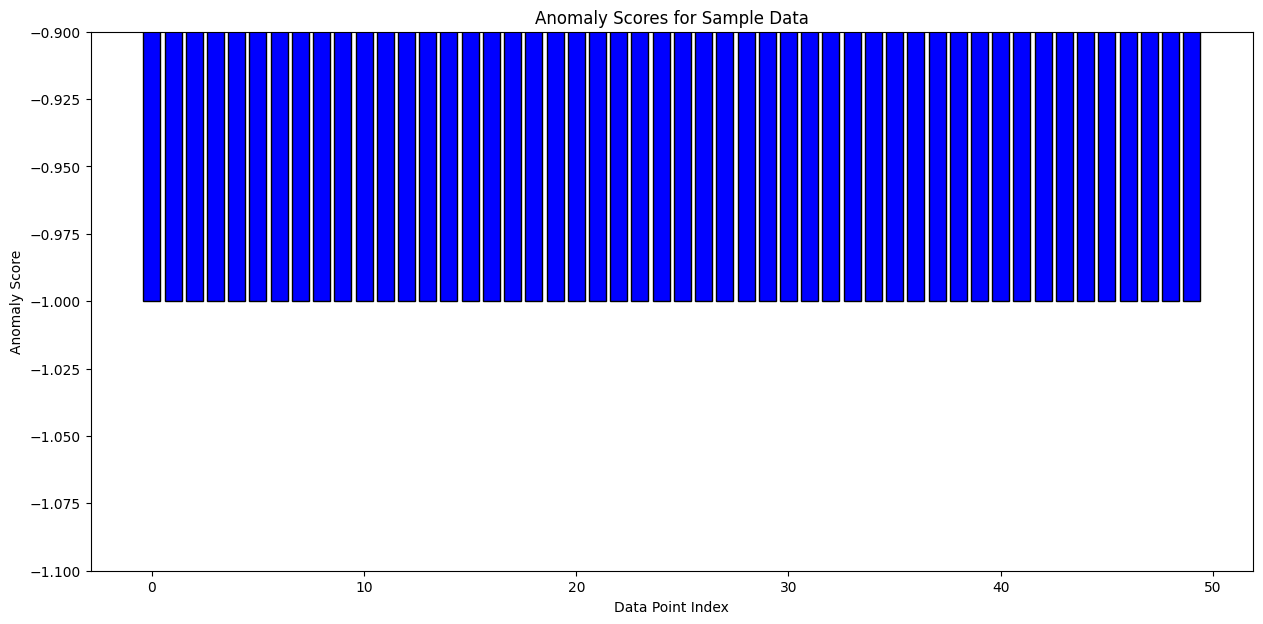

In [348]:
import matplotlib.pyplot as plt

# Get the anomaly scores for each data point (assuming 'output[0]' contains the scores)
anomaly_scores = output[0].flatten()

# Create a bar graph for the anomaly scores
plt.figure(figsize=(15, 7))
plt.bar(range(len(anomaly_scores)), anomaly_scores, color='blue', edgecolor='black')
plt.axhline(y=0, color='r', linestyle='-')  # Red line indicating the threshold for anomaly
plt.ylim(min(anomaly_scores) - 0.1, max(anomaly_scores) + 0.1)  # Adjust y-axis limits
plt.title('Anomaly Scores for Sample Data')
plt.xlabel('Data Point Index')
plt.ylabel('Anomaly Score')
plt.show()

